In [1]:
from engine.models.distance import DistanceMatrix
from engine.models.movie import Movie
import pandas as pd

In [2]:
folder = '/media/mariam/Files/ran/clacket-save'
matrix = DistanceMatrix(folder)
matrix.load()

In [3]:
movies = ['1'] + list(matrix.matrix['1'].keys())

In [8]:
import sys
import random
from math import ceil
        
def testing_set(percentage, movie_ids):
    testing_size = ceil(percentage * len(movie_ids))
    return random.sample(movie_ids, testing_size)

def k_nearest(matrix, id, testing_set, k=5, thresh=None):
    distances = matrix.get_some(id, testing_set)
    start = 1 if id in testing_set else 0  # start from 1 because 0 will always be itself if included
    nearest_k = sorted(distances, key=lambda x: x[1])[start:k+start]
    return [x[0] for x in nearest_k] if thresh is None else [x[0] for x in nearest_k if x[1] >= thresh]

def k_nearest_all(testing_set, matrix, k=5):
    i = 1
    n = len(testing_set)
    for movie_id in testing_set:
        sys.stdout.write('\rCalculating nearest {0} for {1} out of {2}..'.format(k, i, n))
        sys.stdout.flush()
        movie = Movie.load(folder, movie_id)
        nearest = k_nearest(matrix, movie_id, testing_set, k=k)
        users = []
        for near_movie_id in nearest:
            near_movie = Movie.load(folder, near_movie_id)
            positive_users = near_movie.ratings[near_movie.ratings['rating'] > 3]['user_id'].tolist()
            users.extend(positive_users)
        if not hasattr(movie, 'predictions') or movie.predictions is None:
            movie.predictions = {}
        if n not in movie.predictions:
            movie.predictions[n] = {}
        movie.predictions[n][k] = users
        movie.save(folder)
        i += 1

def measure_predictions(movie_id, min, k, n):
    movie = Movie.load(folder, movie_id)
    intersection = movie.ratings[movie.ratings['user_id'].isin(movie.predictions[n][k])]
    hits = intersection[intersection['rating'] >= min].shape[0]
    misses = intersection[intersection['rating'] < min].shape[0]
    return (hits, misses)

def all_predictions(testing_set, min=4, k=5):
    hits = 0
    misses = 0
    n = len(testing_set)
    for movie_id in testing_set:
        m_hits, m_misses = measure_predictions(movie_id, min, k, n)
        hits += m_hits
        misses += m_misses
    return (hits, misses)

def perc(predictions):
    hits, misses = predictions
    total = hits + misses
    hits_p = (hits/total) * 100
    misses_p = (misses/total) * 100
    return (hits, hits_p, misses, misses_p)

def predict(testing_set, matrix, ks=[5], print_only=False):
    results_matrix = {
        'k': [],
        'total_hits_3': [], 'perc_hits_3': [],
        'total_misses_3': [], 'perc_misses_3': [],
        'total_hits_4': [], 'perc_hits_4': [],
        'total_misses_4': [], 'perc_misses_4': []
    }
    for k in ks:
        sys.stdout.write('\rTesting predictions for k={0}..'.format(k))
        sys.stdout.flush()
        results_matrix['k'].append(k)
        if not print_only:
            k_nearest_all(testing_set, matrix, k=k)
        for minimum in [3, 4]:
            predictions = all_predictions(testing_set, min=minimum, k=k)
            hits, hits_p, misses, misses_p = perc(predictions)
            results_matrix['total_hits_{0}'.format(minimum)].append(hits)
            results_matrix['perc_hits_{0}'.format(minimum)].append(hits_p)
            results_matrix['total_misses_{0}'.format(minimum)].append(misses)
            results_matrix['perc_misses_{0}'.format(minimum)].append(misses_p)
    print('Done.')
    return pd.DataFrame(data=results_matrix)

In [ ]:
t_set1 = testing_set(1, movies)
df1 = predict(t_set1, matrix, ks=[3,4,5,6])

In [66]:
import matplotlib.pyplot as plt
import pylab

def plot(df, size_str):
    df.plot.bar(x='k', y=['perc_hits_3', 'perc_hits_4'], ylim=(0,100))
    plt.title('Sample Size: {0}'.format(size_str))
    saved = pylab.savefig('Results_{0}.png'.format(size_str[:-1]))
    plt.show()

/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


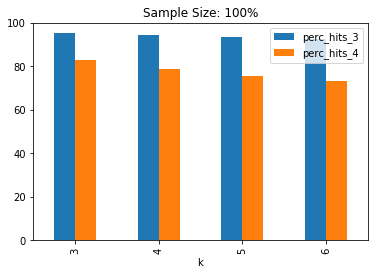

,k,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,3,95.477644,82.979740,4.522356,17.020260,11046645,9600653,523231,1969223
1,4,94.299188,78.925633,5.700812,21.074367,13152467,11008226,795126,2939367
2,5,93.376856,75.708372,6.623144,24.291628,15279508,12388366,1083763,3974905
3,6,92.685254,73.323189,7.314746,26.676811,17212104,13616474,1358384,4954014


In [67]:
plot(df1, '100%')
df1

In [61]:
t_set2 = testing_set(0.7, movies)
df2 = predict(t_set2, matrix, ks=[3,4,5,6])

Calculating nearest 6 for 6580 out of 6580..Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


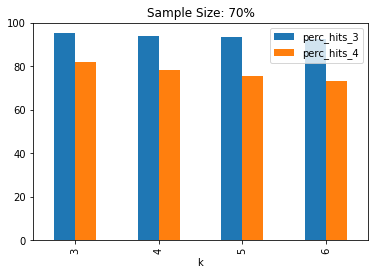

,k,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,3,95.283744,82.156510,4.716256,17.843490,8141530,7019872,402981,1524639
1,4,94.215589,78.367356,5.784411,21.632644,9550085,7943642,586332,2192775
2,5,93.440233,75.830632,6.559767,24.169368,10962724,8896706,769614,2835632
3,6,92.685987,73.395716,7.314013,26.604284,12285319,9728437,969456,3526338


In [68]:
plot(df2, '70%')
df2

In [63]:
t_set3 = testing_set(0.5, movies)
df3 = predict(t_set3, matrix, ks=[3,4,5,6])

Calculating nearest 6 for 4700 out of 4700..Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


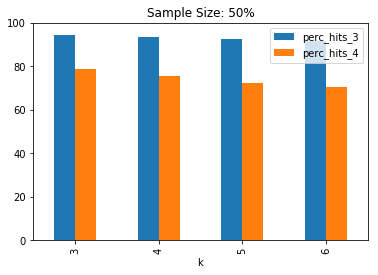

,k,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,3,94.394496,79.003744,5.605504,20.996256,4988263,4174941,296222,1109544
1,4,93.368976,75.423076,6.631024,24.576924,5980169,4830756,424709,1574122
2,5,92.508141,72.629061,7.491859,27.370939,6984027,5483229,565608,2066406
3,6,91.783868,70.526915,8.216132,29.473085,7693299,5911547,688674,2470426


In [69]:
plot(df3, '50%')
df3

In [70]:
t_set4 = testing_set(0.3, movies)
df4 = predict(t_set4, matrix, ks=[3,4,5,6])

Calculating nearest 6 for 2820 out of 2820..Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


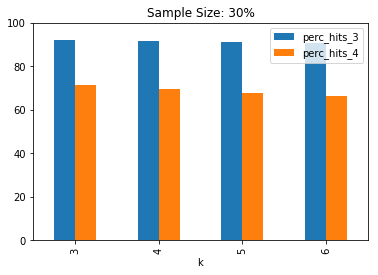

,k,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,3,92.275733,71.361632,7.724267,28.638368,2898390,2241476,242620,899534
1,4,91.811222,69.565875,8.188778,30.434125,3421123,2592204,305135,1134054
2,5,91.160702,67.699246,8.839298,32.300754,3957792,2939200,383763,1402355
3,6,90.655414,66.316043,9.344586,33.683957,4534184,3316836,467375,1684723


In [71]:
plot(df4, '30%')
df4